In [5]:
import math, random
import os, time, datetime
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat
import glob

## This notebook was used to test the saved models when training stoped every 5 hours or so

In [6]:
class DnCNN(nn.Module):
    def __init__(self, n_layers = 17, n_channels=64, image_channels = 1, use_bnorm = True, kernel_size = 3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, 
                                kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(n_layers - 2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, 
                                    kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, 
                                kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        return self.dncnn(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
        print('weights initialized')


## Helper functions

In [13]:
def save_result(result, path):
    path = path if path.find('.') != -1 else path+'.png'
    imsave(path, np.clip(result, 0, 1))
    
def mask(x, a):
    n = x.shape[1]
    m = np.zeros(x.shape)
    
    if a < 1:          # random stripes
        columns_keep = random.sample(range(n),round(a*n))
        m[:,columns_keep] = 1

    elif a > 1:   # regular stripes
        start = random.sample(range(a),1)[0]
        for i in range(n):
            m[:,i] = (i + start)%a != 0     # to vary the pattern for the same a 
    else:
        m[:,:] = 1
    return m
            

def show(x1, x2, x3, x4):
    fig=plt.figure(figsize=(9,9))
#figsize=(8, 6), dpi=80
    plt.subplot(221)
    plt.imshow(x1,vmin=-1, vmax=1, cmap="gray")
    plt.title('ORIGINAL')

    plt.subplot(222)   
    plt.imshow(x2,vmin=-1, vmax=1, cmap="gray")
    plt.title('DOWNSAMPLED')

    plt.subplot(223)   
    plt.imshow(x3,vmin=-1, vmax=1, cmap="gray")
    plt.title('DCNN')
    
    plt.subplot(224)   
    plt.imshow(x4,vmin=-1, vmax=1, cmap="gray")
    plt.title('SCIPY')
   
    plt.show()
#    fig.savefig('results_inter/test.png', bbox_inches='tight')

def rmse(y, x):
    return np.sqrt(((y - x) ** 2).mean())

## SciPy's griddata interpolation of 2D data as a Benchmark

In [9]:
from scipy.interpolate import griddata

def gridInterpolation( d, m):
    x, y = np.indices(d.shape)
    interp = np.array(d)
    interp[m == 0] = griddata((x[m == 1], y[m == 1]), d[m == 1],       # points with values 
                              (x[m == 0], y[m == 0]), method='cubic')  # points to interpolate
    return interp


In [10]:
trained_model = "saved_models/model_029.pth"
cpu_model = torch.load(trained_model, map_location=lambda storage, loc: storage)
cpu_model.eval() 

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=0.0001, momentum=0.95, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=0.0001, momentum=0.95, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=0.0001, momentum=0.95, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=0.0001, momentum=0.95, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size=(3,

In [14]:
file_list = glob.glob('data/landmass1/sa*.mat')
file = random.sample(file_list,1)[0]
rate = random.sample([0.6, 0.7, 0.8, 2,3],1)[0] # type of downsampling
rate = 0.6
print("rate =", rate, file)
x0 = loadmat(file)["img"]
print(x0.shape)
m = mask(x0, rate)
x1 = x0 * m
x2 = gridInterpolation( x1, m)

x3 = cpu_model(torch.from_numpy(x1).view(1, -1, x1.shape[0], x1.shape[1]))  # inference
x3 = x3.view(x1.shape[0], x1.shape[1]) 
x3 = x3.cpu()
x3 = x3.detach().numpy().astype(np.float32)

rate = 0.6 data/landmass1/saltdome_1868.mat
(99, 99)


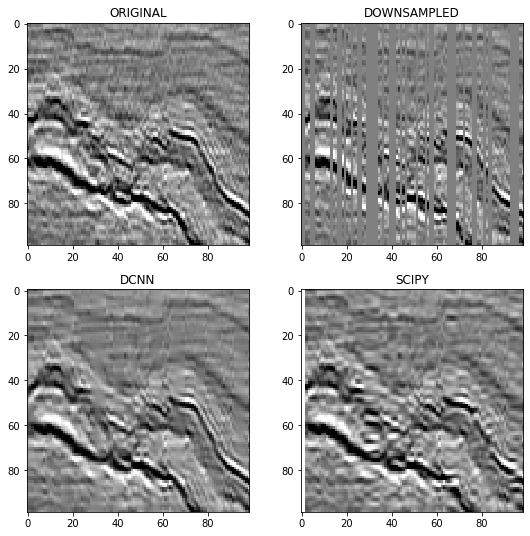

In [15]:
show(x0, x1, x3, x2)

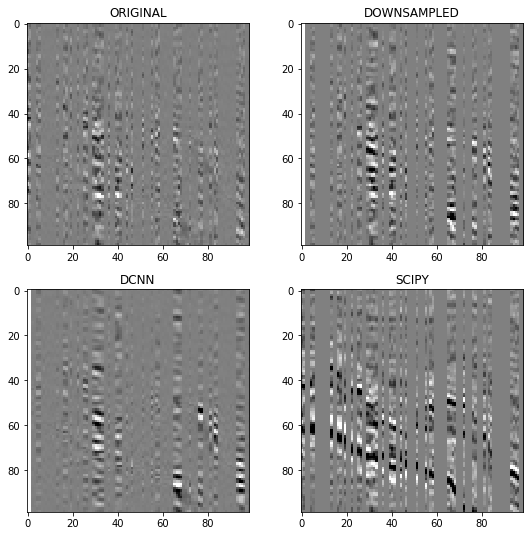

In [16]:
show(x0-x3, x0-x2, x2-x3, x0-x1)